# Standard Layers

We will now see an overview of the enormous diversity in deep learning layers. This survey is necessarily limited to standard layers and we begin *without* considering the key layers that enable deep learning of molecules and materials. Almost all the layers listed below came out of a model for a specific task and were not thought-up independently. That means that some of the layers are suited to specific tasks and often the nomenclature around that layer is targeted towards a specific kinds of data. 


```{admonition} Audience & Objectives
This chapter builds on the overview from {doc}`introduction` and {doc}`../ml/regression`. After completing this chapter, you should be able to:

  * Construct a neural network with various layers
  * Understand how layers change shapes
  * Recognize hyperparameters in a neural network
  * Split data into train, test, and validation
  * Regularize to prevent overfitting
```

The most common type is image data and we first begin with an overview of how image features are represented. Generally, an image is a rank 3 tensor with shape $(H, W, C)$ where $H$ is the height of the image, $W$ is the width, and $C$ is the number of channels (typically 3 -- red, green, blue). Since all training is in batches, the input features shape will be $(B, H, W, C)$. Often layers will discuss input as having a batch axis, some number of shape axes, and then finally a channel axis. The layers will then operate on perhaps only the channels or only the shape dimensions. The layers are all quite flexible, so this is not a limitation in practice, but it's important to know when reading about layer types. Often the documentation or literature will mention *batch number* or *channels* and this is typically the first and last axes of a tensor, respectively. 

```{note}
Everything and nothing is batched in deep learning. Practically, data is always batched. Even if your data is not batched, the first axis input to a neural network is of unspecified dimension and called the batch axis. Many frameworks make this implicit, meaning if you say the output from one layer is shape $(4,5)$, it will be $(B, 4, 5)$ when you actually inspect data. Or, for example in JAX, you can write your code without batching and make it batched through a function transform. So, all data is batched but often the math, frameworks, and documentation make it seem as if there is no batch axis. 
```

```{figure} ../_static/images/nn.svg
---
width: 600px
name: fig-nn
---
A typical neural network architecture is composed of multiple layers. This network is used to classify images.
```

An example of what a neural network looks like is shown in {numref}`fig-nn`. In this case, its input is a 128x128 images with 3 channels (red, green, blue) and it outputs is a vector of probabilities of length 128 that indicate the class of the images. In other words, it takes in an image and gives it a probability of 128 possible labels like "cat" or "vase" or "crane". The words annotating the figure indicate the different layer types we'll learn about below.

## Hyperparameters

We saw from the Full connected (FC)/Dense layer that we have to choose if we use bias, the activation, and the output shape. As we learn about more complex layers, there will be more choices. These choices begin to accumulate and in a neural network you may have billions of possible combinations of them. These choices about shape, activation, initialization, and other layer arguments are called **hyperparameters**. They are parameters in the sense that they can be tuned, but they are not trained on our data so we call them hyperparameters to distinguish them from the "regular" parameters like value of weights and biases in the layers. The name is inherited from Bayesian statistics. 

Choosing these hyperparameters is difficult and we typically rely on the body of existing literature to understand ranges of reasonable parameters. In deep learning, we usually are in a regime of hyperparameters which yield many trainable parameters (deep networks) and thus our models can represent any function. Our models are expressive. However, optimizing hyperparameters makes training faster and/or require less data. For example, papers have shown that carefully choosing the initial value of weights can be more effective than complex architecture {cite}`glorot2010understanding`. Another example found that convolutions, which are thought to be the most important layer for image recognition, are not necessary if hyperparameters are chosen correctly for dense neural networks{cite}`noconv`. This is now changing, with options for tuning hyperparameters, but the current state-of-the art is to take hyperparameters from previous work as a starting guess and change a little if you believe it is needed. 

### Validation

The number of hyperparameters is high enough that overfitting can actually occur by choosing hyperparameters that minimize error on the test set. This is surprising because we don't explicitly train hyperparameters. Nevertheless, you will find in your own work that if you use the test data extensively in hyperparameter tuning and for assessing overfitting of the regular training parameters, your performance will be overfit to the testing data. To combat this, we split our data three ways in deep learning:

1. Training data: used for trainable parameters. 
2. Validation data: used to choose hyperparameters or measure overfitting of training data
3. Test data: data not used for anything except final reported error 

To clean-up our nomenclature here, we use the word **generalization error** to refer to performance on a hypothetical infinite stream of unseen data. So regardless of if you split three-ways or use other approaches, generalization error means error on unseen data. 

```{margin}
You can replace this three-way split with cross-validation methods from previously, but remember that those require training $k$-times. Thus you rarely see k-fold cross-validation and even more rarely see leave-one-out or Jacknife because of how computatioanlly expensive it is to train models.
```

### Tuning

So how do you tune hyperparameters? The main answer is by hand, but this is an active area of research. Hyperparameters are continuous (e.g., regularization strength), categorical (e.g., which activation), and discrete variables (e.g., number of layers). One category of ways to tune hyperparameters is a topic called meta-learning{cite}`finn2017model`, which aims to learn hyperparameters by looking at multiple related datasets. Another area is auto-machine learning (auto-ML){cite}`45826`, where optimization strategies that do not require derivatives can tune hyperparameters. An important category of optimization related to hyperparameter tuning is **multi-armed bandit** optimization where we explicitly treat the fact that we have a finite amount of computational resources for tuning hyperparameters{cite}`hyperband`. A comprehensive overview on hyperparameters and tuning techniques can be found in {doc}`Hyperparameter_tuning`.

## Common Layers

Now that we have some understanding of hyperparameters and their role, let's now survey the common types of layers.

### Convolutions

You can find a more thorough overview of [convolutions here](http://d2l.ai/chapter_convolutional-neural-networks/why-conv.html) and [here with more visuals](https://cs231n.github.io/convolutional-networks/). Here is a [nice video on this](https://www.youtube.com/watch?v=x_VrgWTKkiM). Convolutions are the most commonly used input layer when dealing with images or other data defined on a regular grid. In chemistry, you'll see convolutions on protein or DNA sequences, on 2D imaging data, and occasionally on 3D spatial data like average density from a molecular simulation. What makes a convolution different from a dense layer is that the number of trainable weights is more flexible than input grid shape $\times$ output shape, which is what you would get with a dense layer. Since the trainable parameters don't depend on the input grid shape, you don't learn to depend on location in the image. This is important if you're hoping to learn something independent of location on the input grid -- like if a specific object is present in the image independent of where it is located.

In a convolution, you specify a **kernel shape** that defines the size of trainable parameters. The kernel shape defines a window over your input data in which a dense neural network is applied. The rank of the kernel shape is the rank of your grid + 1, where the extra axis accounts for channels. For example, for images you might define a kernel shape of $5\times5$. The kernel shape will become $5\times5\times{}C$, where $C$ is the number of channels. When referring to a convolution as 1D, 2D, or 3D, we're referring to the grid of the input data and thus the kernel shape. A 2D convolution actually has an input of rank 4 tensors, the extra 2 axes accounting for batch and channels. The kernel shape of $5\times5$ means that the output of a specific value in the grid will depend on its 24 nearest neighboring pixels (2 in each direction). Note that the kernel is used like a normal dense layer -- it can have bias (dimension $C$), output activation, and regularization. 

Practically, convolutions are always grouped in parallel. You have a set of $F$ kernels, where $F$ is called the number of **filters**. Each of these filters is completely independent and if you examine what they learn, some filters will learn to identify squares and some might learn to identify color or others will learn textures. Filters is a term left-over from image processing, which is the field where convolutions were first explored. Combining all of these together, a 2D convolution will have an input shape of $(B, H, W, C)$ and an output of $(B, \approx H, \approx W, F)$, where $F$ is the number of filters chosen, and the $\approx$ accounts for the fact that when you slide your kernel window over the input data, you'll lose some values on the edge. This can either be treated by padding, so your input height and width match output height and width, or your dimensionality is reduced by a small amount (e.g., going from $128\times128$ to $125\times125$). A 1D convolution will have input shape $(B, L, C)$ and output shape $(B, \approx L, F)$. As a practical example, consider a convolution on DNA. $L$ is length of the sequence. $C$, your channels, will be [one-hot indicators](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) for the base (T, C, A, G).

```{margin} padding
Padding means insert some constants to make a tensor increase in shape. For example, if I want all my tensors to be of shape (32,32) and some are smaller, I could pad by adding 0s until the shape is (32,32).
```

One of the important properties we'll begin to discuss is **invariances** and **equivariances**. An invariance means the output from a neural network (or a general function) is insensitive to changes in input. For example, a translational invariance means that the output does not change if the input is translated. Convolutions and pooling should be chosen when you want to have **translation invariance**. For example, if you are identifying if a cat exists in an image, you want your network to give the same answer even if the cat is translated in the image to different regions. However, just because you use a convolution layer does not make a neural network automatically translationally invariant. You must include other layers to achieve this.  Convolutions are actually translationally equivariant -- if you translate all pixels in your input, the output will also be translated. People usually do not distinguish between equivariance and invariance. If you are trying to identify *where* a cat is located in an image you would still use convolutions but you want your neural network to be translationally equivariant, meaning your guess about where the cat is located is sensitive to where the cat is located in the input pixels. The reason convolutions have this property is that the trainable parameters, the kernel, are location independent. You use the same kernel on every region of the input. 

```{margin} equivariance
It's a bit more complicated. Convolutions and pooling are *almost* translationally equivariant. There are edge effects because images are not infinitely wide so something special always must be done to deal with pixels near the edges of images, which prevents them from being fully equivariant.
```

### Pooling

Convolutions are commonly paired with pooling layers because pooling also is translationally equivariant. If your goal is to produce a single number (regression) or class (classification) from an input image or sequence, you need to reduce the rank to 0, a scalar. After a convolution, you could use a reduction like average or maximum. It has been shown empirically that reducing the number of elements of your features more gradually is better. One way is through **pooling**. Pooling is similar to convolutions, in that you define a kernel shape (called window shape), but pooling has no trainable parameters. Instead, you run a window across your input grid and compute a reduction. Commonly an average or maximum is computed. If your pool window is a $2\times2$ on an input of $(B, H, W, F)$, then your output will be $(B, H / 2, W / 2, F)$. In convolutional neural networks, often multiple **blocks** of convolutions and poolings are combined. For example, you might use three rounds of convolutions and pooling to take an image from $32 \times 32$ down to a $4 \times 4$. Read more about [pooling here](http://d2l.ai/chapter_convolutional-neural-networks/pooling.html)



### Embedding

Another important type of input layers are **embeddings**. Embeddings convert integers into vectors. They are typically used to convert characters or words into numerical vectors. The characters or words are first converted into **tokens** separately as a pre-processing step and then the input to the embedding layer is the indices of the token. The indices are integer values that index into a dictionary of all possible tokens. It sounds more complex than it is. For example, we might tokenize characters in the alphabet. There are 26 tokens (letters) in the alphabet (dictionary of tokens) and we could convert the word "hello" into the indices $[7, 4, 11, 11, 14]$, where 7 means the 7th letter of the alphabet. 

After converting into indices, an embedding layer converts these indices into dense vectors of a chosen dimension. The rationale behind embeddings is to go from a large discrete space (e.g., all words in the English language) into a much smaller space of real numbers (e.g., vectors of size 5). You might use embeddings for converting monomers in a polymer into dense vectors or atom identities in a molecule or DNA bases. We'll see an embedding layer in the example below.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages.

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell. 

```
!pip install dmol-book
```

If you find install problems, you can get the latest working versions of packages used in [this book here](https://github.com/whitead/dmol-book/blob/master/package/setup.py)

````

In [1]:
!pip install dmol-book

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.7 MB/s 
     |████████████████████████████████| 83 kB 1.4 MB/s 
     |████████████████████████████████| 117 kB 36.6 MB/s 
     |████████████████████████████████| 4.7 MB 35.8 MB/s 
     |████████████████████████████████| 29.5 MB 2.0 MB/s 
     |████████████████████████████████| 3.2 MB 30.7 MB/s 
     |████████████████████████████████| 128 kB 52.1 MB/s 
     |████████████████████████████████| 3.5 MB 37.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 350 kB 50.9 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 250 kB 65.5 MB/s 
     |████████████████████████████████| 57 kB 4.5 MB/s 
     |████████████████████████████████| 145 kB 55.8 MB/s 
     |███████████████████████

## Example

At this point, we have enough common layers to try to build a neural network. We will combine these three layers to predict if a protein is soluble. Our dataset comes from {cite}`solubility` and consists of proteins known to be soluble or insoluble. As usual, the code below sets-up our imports.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib
import dmol

Our task is binary classification. The data is split into two: positive and negative examples. We'll need to rearrange a little into a normal dataset with labels and training/testing split. We also really really need to shuffle our data, so it doesn't see all positives and then all negatives.

In [2]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/solubility.npz",
    "solubility.npz",
)
with np.load("solubility.npz") as r:
    pos_data, neg_data = r["positives"], r["negatives"]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i) 
labels = labels[i]
features = features[i]
full_data = tf.data.Dataset.from_tensor_slices((features, labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
print(N, "examples")
split = int(0.1 * N)
test_data = full_data.take(split).batch(16)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

18453 examples


Before getting to modeling, let's examine our data. The protein sequences have already been tokenized. There are 20 possible values at each position because there are 20 amino acids possible in proteins. Let's see a soluble protein

In [7]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [4]:
pos_data[0]

array([13, 17, 15, 16,  1,  1,  1, 17,  8,  9,  7,  1,  1,  4,  7,  6,  2,
       11,  2,  7, 11,  2,  8, 11, 17,  2,  6, 11, 15, 17,  8, 20,  1, 20,
       20, 17,  1,  6,  4,  8,  7, 20,  1,  9,  8,  1, 17, 20, 16, 17, 20,
       16, 20, 11, 16,  6,  6, 15, 11,  2, 10,  8, 20, 16, 11,  2,  2,  8,
       16, 19, 11, 17,  8, 11, 10,  2,  6,  2,  2, 20, 14,  1, 11,  3, 20,
       11, 16, 16,  2,  6, 16,  1, 20,  1,  4, 18, 14,  1,  3, 15,  7,  2,
       15,  2,  8, 18,  2,  6, 14,  4, 19, 20,  2, 18, 17,  1,  9, 15, 12,
        1,  8, 13, 15, 20, 11,  7,  4,  1, 11,  1,  6, 11,  9,  5,  2, 11,
       17,  4, 11, 10, 15, 11,  8,  1, 16,  4,  4, 11, 11, 20,  1,  7, 20,
       11,  4,  8,  2,  8,  2,  3,  8,  2, 15, 11, 20,  3, 14,  3,  8,  2,
       11,  9,  4, 20,  7, 14,  2,  8, 20, 20,  2, 20, 16,  2,  4,  6, 15,
       16,  1, 20, 17, 16, 11,  7,  0,  0,  0,  0,  0,  0])

Notice that integers/indices are used because our data is tokenized already. To make our data all be the same input shape, a special token (0) is inserted at the end indicating no amino acid is present. This needs to be treated carefully, because it should be zeroed throughout the network. Luckily this is built into Keras, so we do not need to worry about it. 

This data is perfect for an embedding because we need to convert token indices to real vectors. Then we will use 1D convolutions to look for sequence patterns with pooling. We need to then make sure our final layer is a sigmoid, just like in {doc}`../ml/classification`. This architecture is inspired by the original work on pooling with convolutions {cite}`LeNet`. The number of layers and kernel sizes below are hyperparameters. You are encouraged to experiment with these or find improvements!

We begin with an embedding. We'll use a 2-dimensional embedding, which gives us two channels for our sequence. We'll just choose our kernel filter size for the 1D convolution to be 5 and we'll use 16 filters. Beyond that, the rest of the network is about distilling gradually into a final class. 

In [3]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           336       
                                                                 
 conv1d (Conv1D)             (None, 196, 16)           1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 16)            7

Take a moment to look at the model summary (shapes). This is a fairly complex neural network. If you can understand this, you'll have a grasp on most current networks used in deep learning. Now we'll begin training. Since we are doing classification, we'll also examine accuracy on validation data as we train. 

In [9]:
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=5, verbose=0)

In [10]:
result.history

{'loss': [0.6388901472091675,
  0.6295597553253174,
  0.6166161894798279,
  0.603781521320343,
  0.5880613327026367],
 'accuracy': [0.629004955291748,
  0.6361173391342163,
  0.6538643836975098,
  0.664160430431366,
  0.6827203035354614],
 'val_loss': [0.6865383982658386,
  0.6797195076942444,
  0.7252241969108582,
  0.6802704334259033,
  0.7449313998222351],
 'val_accuracy': [0.5728996992111206,
  0.5756097435951233,
  0.5620596408843994,
  0.5799458026885986,
  0.5696476697921753]}

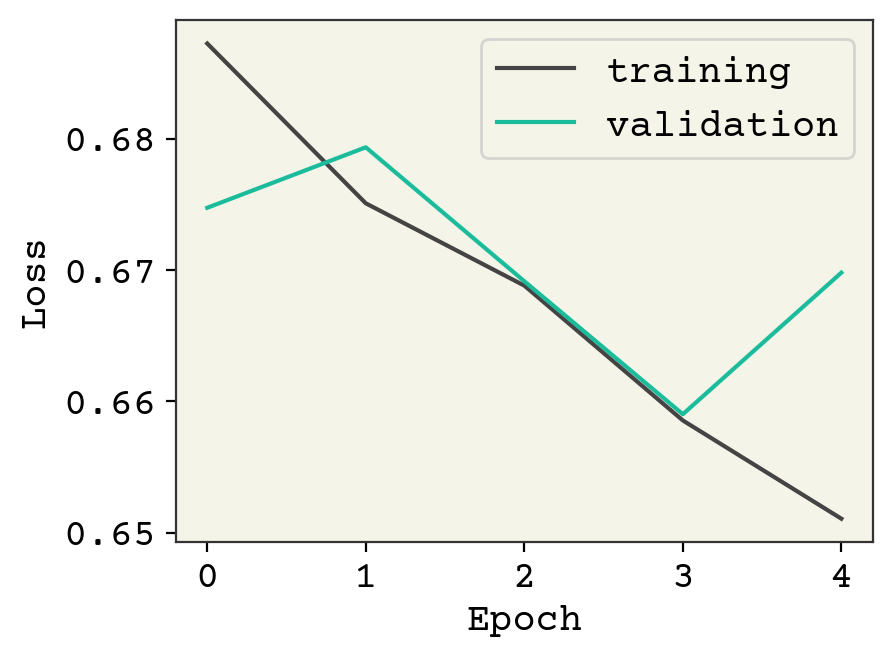

In [5]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

You can see this is a classic case of overfitting, with the validation data rising quickly as we improve our loss on the training data. Indeed, our model is quite expressive in its capability to fit the training data but it is incidentally fititng the noise. We have 61,000 trainable parameters and about 15,000 training examples, so this is not a surprise. However, we still able to learn a little bit -- our accuracy is above 50%. This is actually a challenging dataset and the state-of-the art result is 77% accuracy {cite}`deepsol`. We need to expand our tools to include layers that can address overfitting. 

## Back propagation

At this stage, we should probably talk about back propagation and its connection to automatic gradient computation (autograds). This is how training "just works" when we take a gradient. This is actually a bit of a complicated topic, but it also nearly invisible to users of modern deep learning packages. Thus, I have chosen to not cover it in this book. You can find comprehensive discussions of modern autograd in {cite}`baydin2018automatic` and in the [Jax manual](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html).

## Regularization

As we saw in the ML chapters, regularization is a strategy that changes your training procedure (often by adding loss terms) to prevent overfitting. There is a nice argument for it in the bias-variance trade-off regarding model complexity, however this doesn't seem to hold in practice {cite}`neal2018modern`. Thus, we view regularization as an empirical process. Regularization, like other hyperparameter tuning, is dependent on the layers, how complex your model is, your data, and especially if your model is underfit or overfit. Underfitting means you could train longer to improve validation loss. Adding regularization if your model is underfit will usually reduce performance. Consider training longer or adjusting learning rates if you observe this. 


### Early Stopping

The most commonly used and simplest form of regularization is **early stopping**. Early stopping means monitoring the loss on your validation data and stopping training once it begins to rise. Normally, training is done until converged -- meaning the loss stops decreasing. Early stopping tries to prevent overfitting by looking at the loss on unseen data (validation data) and stopping once that begins to rise. This is an example of regularization because the weights are limited to move a fixed distance from their initial value. Just like in L2 regularization, we're squeezing our trainable weights. Early stopping can be a bit more complicated to implement in practice than it sounds, so check out how frameworks do it before trying to implement yourself (e.g., {obj}`tf.keras.callbacks.EarlyStopping`).

### Weight 

**Weight regularization** is the addition of terms to the loss that depend on the trainable weights in the solubility model example. These can be L2 ($\sqrt{\sum w_i^2}$) or L1 ($\sum \left|w_i\right|$). You must choose the strength, which is expressed as a parameter (often denoted $\lambda$) that should be much less than $1$. Typically values of $0.1$ to $1\times10^{-4}$ are chosen. This may be broken into **kernel regularization**, which affects the multiplicative weights in a dense or convolution neural network, and **bias regularization**. Bias regularization is rarely seen in practice. 

### Activity

**Activity regularization** is the addition of terms to the loss that depend on the *output* from a layer. Activity regularization ultimately leads to minimizing weight magnitudes, but it makes the strength of that effect depend on the output from the layers. Weight regularization has the strongest effect on weights that have little effect on layer output, because they have no gradient if they have little effect on the output. In contrast, activity regularization has the strongest effect on weights that greatly affect layer output. Conceptually, weight regularization reduces weights that are unimportant but could harm generalization error if there is a shift in the type of features seen in testing. Activity regularization reduces weights that affect layer output and is more akin to early stopping by reducing how far those weights can move in training. 

### Batch Normalization

It is arguable if batch normalization is a regularization technique -- there have been probably 10,000 papers on why it works. Batch normalization is a layer that is added to a neural network with trainable weights, but its trainable weights are not updated via gradient descent of the loss. Batch normalization has a layer equation of:


\begin{equation}
f(X) = \frac{X - \bar{X}}{S}
\end{equation}

where $\bar{X}$ and $S$ are the sample mean and variance taken across the batch axis (zeroth axis of $X$). This has the effect of "smoothing" out the magnitudes of values seen between batches. Remember that activations like ReLU depend on values being near 0 (since the nonlinear part is at $x = 0$) and tanh has the most change in output around $x = 0$, so you typically want your intermediate layer outputs to be around $0$. At inference time you may not have batches or your batches may be a different size, so $\bar{X}$ and $S$ are set to the average across all batches seen in training data. A common explanation of batch normalization is that it smooths out the optimization landscape by forcing layer outputs to be approximately normal{cite}`santurkar2018does`.

```{margin}
**Inference** is the word for when you use your model to make predictions. Training is when you train the model and inference is when you use the model. 
```

#### Layer Normalization

Batch normalization depends on there being a constant batch size. Some kinds of data, like text or a graphs, have different sizes and so the batch mean/variance can change significantly. **Layer normalization** avoids this problem by normalizing across the *features* (the non-zero axes) instead of the batch. This has a similar effect of making the layer output features behave well-centered at 0 but without having highly variable means/variances because of batch to batch variation. You'll see these in graph neural networks and recurrent neural networks, with both take variable sized inputs. 

### Dropout

The last regularization type is **dropout**. Like batch normalization, dropout is typically viewed as a layer and has no trainable parameters. In dropout, we randomly zero-out specific elements of the input and then rescale the output so its average magnitude is unchanged. You can think of it like *masking*. There is a mask tensor $M$ which contains 1s and 0s and is multiplied by the input. It is called masking because we mask whatever was in the elements that were multiplied by 0. Then the output is multiplied by $|M|  / \sum M$ where $|M|$ is the number of elements in $M$. Dropout forces your neural network to learn to use different features or "pathways" by zeroing out elements. Weight regularization squeezes unused trainable weights through minimization. Dropout tries to force all trainable weights to be used by randomly negating weights. Dropout is more common than weight or activity regularization but has arguable theoretical merit. Some have proposed it is a kind of sampling mechanism for exploring model variations{cite}`gal2016dropout`. Despite it appearing ad-hoc, it is effective. Note that dropout is only used during training, not for inference. You need to choose the dropout rate when using it, another hyperparameter. Usually, you will want to choose a rate of 0.05--0.35. 0.2 is common. Too small of a value -- meaning you rarely do dropout -- makes the effect too small to matter. Too large of a value -- meaning you often dropout values -- can prevent you from actually learning. As fewer nodes get updated with dropout, larger learnings rates with decay and a larger momentum can help with the model's performance.

```{figure} ./drop_out.gif
----
name: drop_out
width: 250px
----
Dropout. 
```

## Residues

One last "layer" note to mention is residues. One of the classic problems in neural network training is **vanishing gradients**. If your neural network is deep and many features contribute to the label, you can have very small gradients during training that make it difficult to train. This is visible as underfitting. One way this can be addressed is through careful choice of optimization and learning rates. Another way is to add "residue" connections in the neural network. Residue connections are a fancy way of saying "adding" or "concatenating" later layers with early layers. The most common way to do this is:

\begin{equation}
X^{i + 1} = \sigma(W^iX^i + b^i) + X^i
\end{equation}

This is the usual equation for a dense neural network but we've added the previous layer output ($X^i$) to our output. Now when you take a gradient of earlier weights from layer $i - 1$, they will appear through both the $\sigma(W^iX^i + b^i)$ term via the chain rule and the $X^i$ term. This goes around the activation $\sigma$ and the effect of $W^i$. Note this continues at all layers and then a gradient can propagate back to earlier layers via either term. You can add the "residue" connection to the previous layer as shown here or go back even earlier. You can also be more complex and use a trainable function for how the residue term ($X^i$) can be treated. For example:

\begin{equation}
X^{i + 1} = \sigma(W^iX^i + b^i) + W'^i X^i
\end{equation}

where $W'^i$ is a set of new trainable parameters. We have seen that there are many hyperparametes for tuning and adjusting residue connections is one of the least effective things to adjust. So don't expect much of an improvement. However, if you're seeing underfitting and inefficient training, perhaps it's worth investigating.

## Blocks

You can imagine that we might join a dense layer with dropout, batch normalization, and maybe a residue. When you group multiple layers together, this can be called a **block** for simplicity. For example, you might use the word "convolution block" to describe a sequential layers of convolution, pooling, and dropout.

## Dropout Regularization Example

Now let's try to add a few dropout layers to see if we can do better on our example above. 

In [17]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
# NOTE: Keras doesn't respect masking here
# I should switch to PyTorch.
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

# Here is the dropout
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 16)           336       
                                                                 
 conv1d_9 (Conv1D)           (None, 196, 16)           1296      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 49, 16)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 47, 16)            784       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 23, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 21, 16)           

In [18]:
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=0)

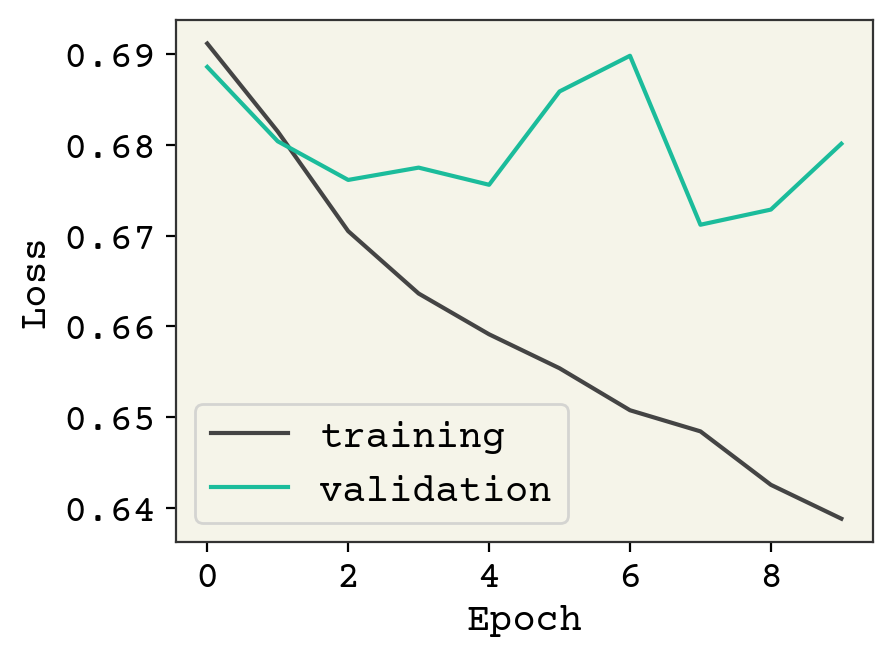

In [19]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We added a few dropout layers and now we can see the validation loss is a little better but additional training will indeed result it in rising. Feel free to try the other ideas above to see if you can get the validation loss to decrease like the training loss. 

## L2 Weight Regularization Example
Now we'll demonstrate adding weight regularization.

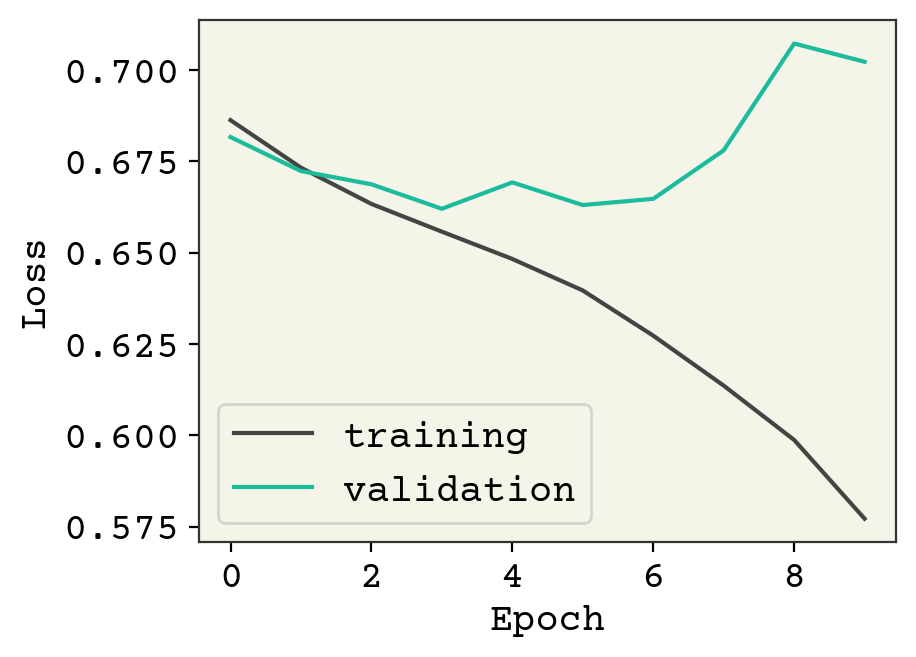

In [24]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

# HERE IS THE REGULARIZATION:
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu",kernel_regularizer="l1")) 
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=0)

plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

L2 regularization is too strong it appears, preventing learning. You could go back and reduce the strength; here we're just using the default which doesn't look appropriate for our setting. Tuning hyperparameters like this is a favorite past time of neural network engineers and we could go on forever. We'll stop here and leave it as an exercise for the reader to continue exploring hyperparameters. 

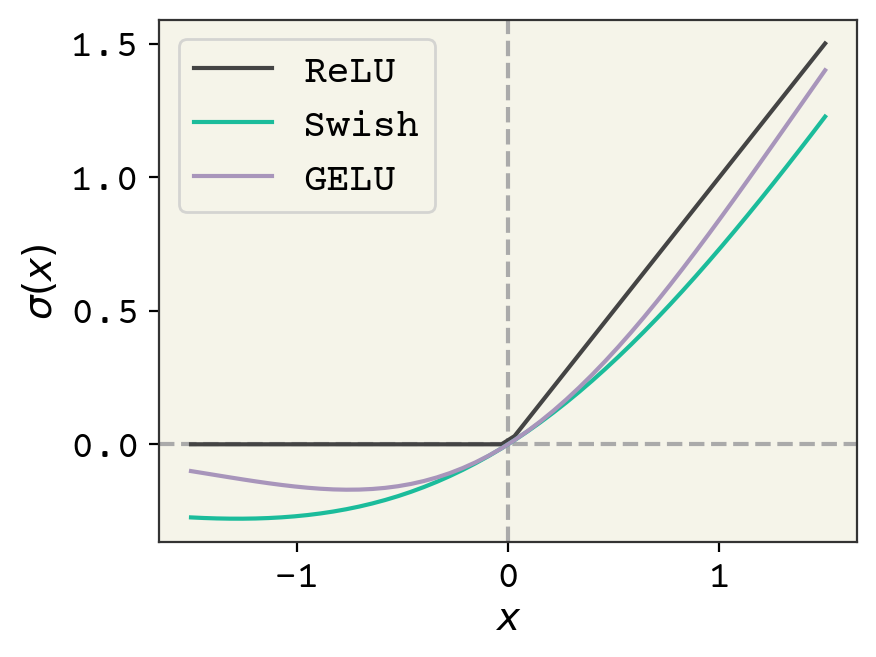

In [25]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT


from myst_nb import glue


def gelu(x):
    return tf.keras.activations.gelu(x)


def swish(x):
    return tf.keras.activations.sigmoid(x) * x


def relu(x):
    return np.where(x < 0, np.zeros_like(x), x)


plt.figure()
x = np.linspace(-1.5, 1.5)
plt.axvline(x=0, linestyle="--", color="#AAA")
plt.axhline(y=0, linestyle="--", color="#AAA")
plt.plot(x, relu(x), label="ReLU")
plt.plot(x, swish(x), label="Swish")
plt.plot(x, gelu(x), label="GELU")
plt.xlabel("$x$")
plt.ylabel("$\sigma(x)$")
plt.legend()
glue("activations", plt.gcf(), display=False)

## Activation Functions

Recall in {doc}`introduction` we mentioned that activation functions must be nonlinear and we often want them to have a region of input where the output value is zero. ReLU is the simplest example that satisfies these conditions - its output is zero for negative inputs and $f(x) = x$ for positive values. Choosing activation is another hyperparameter and choice that we make. People used activations like $\tanh$ or sigmoids in early neural network research. ReLU began to dominate in modern deep learning because it's so efficient that models could be made larger for the same runtime speed. 

```{glue:figure} activations
----
name: activations
----
Comparison of the usual ReLU activation function and GELU and Swish.
```

Since 2019, this has been revisited because modern GPUs can run a variety of activation functions now quite quickly{cite}`eger2019time`. Two commonly used modern activation functions are Gaussian Error Linear Units (GELU){cite}`hendrycks2016gaussian` and Swish{cite}`eger2019time`. They are shown in {numref}`activations`. They have these two properties of nonlinearity and an ability to turn-off at negative values. They seem to give better results because of their non-zero gradient at negative values; they can continue to respond to gradients while they are turned off. It is more common now to see Swish than ReLU in most newer networks and GELU is specifically seen in transformers (discussed in {doc}`NLP`.

The equation for Swish is:

$$
\sigma(x) = x \cdot\textrm{sigmoid}(x) = x \frac{1}{1 + e^{-x}}
$$

and the equation for GELU is:

$$
\sigma(x) = x\cdot \Phi(x) = x\cdot {\displaystyle {\frac {1}{2}}\left[1+\operatorname {erf} \left({\frac {x-\mu }{\sigma {\sqrt {2}}}}\right)\right]}
$$

## Discussion

Designing and training neural networks is a complex task. The best approach is to always start simple and work your way up in complexity. Remember, you have to write correct code, create a competent model, and have clean data. If you start with a complex model it can be hard to discern if learning problems are due to bugs, the model, or the data. My advice is to always start with a pre-trained or simple baseline network from a previous paper. If you find yourself designing and training your own neural network, read through Andrej Karpathy's [excellent guide](http://karpathy.github.io/2019/04/25/recipe/) on how to approach this task. 

## Chapter Summary 

* Layers are created for specific tasks, and given the variety of layers, there are a vast number of permutations of layers in a deep neural network. 
* Convolution layers are used for data defined on a regular grid (such as images). In a convolution, one defines the size of the trainable parameters through the kernel shape.
* An invariance is when the output from a neural network is insensitive to spatial changes in the input (translation, rotation, rearranging order)
* An equivariance is when the output from a neural network changes the same way as the input. See {doc}`data` and {doc}`Equivariant` for concrete definitions.
* Convolution layers are often paired with pooling layers. A pooling layer behaves similarly to a convolution layer, except a reduction is computed and the output is a smaller shape (same rank) than the input.
* Embedding layers convert indices into vectors, and are typically used as pre-processing steps. 
* Hyperparameters are choices regarding the shape of the layers, the activation function, initialization parameters, and other layer arguments. They can be tuned but are not trained on the data.
* Hyperparameters must be tuned by hand, as they can be continuous, categorical, or discrete variables, but there are algorithms being researched that tune hyperparameters. 
* Tuning the hyperparameters can make training faster or require less training data.
* Using a validation data set can measure the overfitting of training data, and is used to help choose the hyperparameters.
* Regularization is an empirical technique used to change training procedures to prevent overfitting. There are five common types of regularization: early stopping, weight regularization, activity regularization, batch normalization, and dropout. 
* Vanishing gradient problems can be addressed by adding "residue" connections, essentially adding later layers with early layers in the neural network. 

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```